### TFG AÑO- Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de año a año (252 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [2]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [3]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [4]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2015-12-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testAño.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testAño.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [5]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testAño.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testAño.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [6]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  33.33333333333333 % de los datos
LLeva descargados el  66.66666666666666 % de los datos

Ha tardado en descargar los datos: 10.8876993656 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  33.33333333333333 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test

Ha tardado en descargar los datos test: 4.6528773308 segundos.




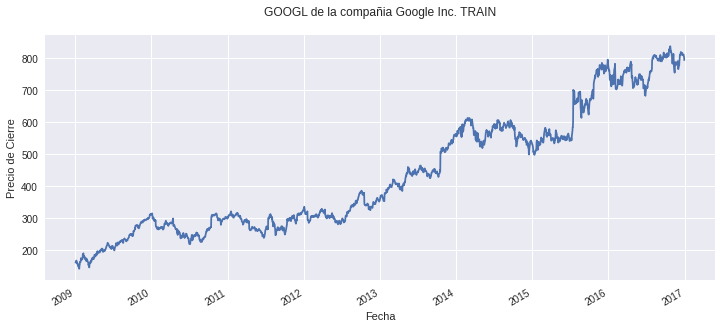

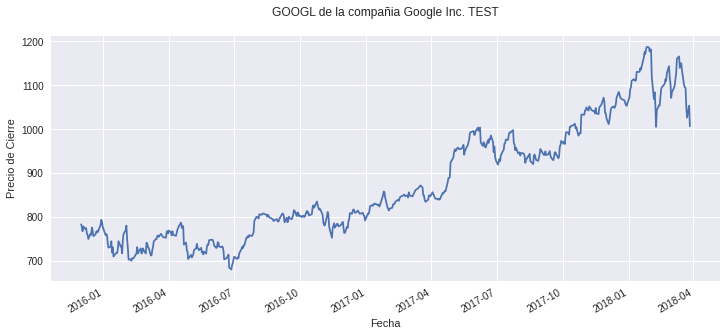

In [7]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 2
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [8]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [9]:
# A parte de la creacion de atributos
index = ran
timeStep = 252 # longitud de secuencias que se hacen en cada iteracion de la red (un año entero)

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo GOOGL de la compañia Google Inc.


In [10]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

# Creacion de la red neural LSTM

In [18]:
model42 = Sequential()
model42.add(LSTM(4, input_shape=(252,3),return_sequences=True))
model42.add(LSTM(units = 2,return_sequences = False))
model42.add(Dense(1)) 
model42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model42.summary()
history_LSTM42 = model42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 4)            128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 13s 364ms/step - loss: 253418.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 252587.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 340ms/step - loss: 253185.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 252387.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [======

Epoch 42/1500
37/37 [==============================] - 13s 340ms/step - loss: 247985.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 247243.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 12s 336ms/step - loss: 247879.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 247137.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 12s 333ms/step - loss: 247773.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 247032.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 12s 337ms/step - loss: 247668.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 246927.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 12s 337ms/step - loss: 247563.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 246822.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 13s 340ms/step - loss: 247458.5625 

37/37 [==============================] - 12s 335ms/step - loss: 243338.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 242609.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
37/37 [==============================] - 13s 343ms/step - loss: 243237.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 242508.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 12s 337ms/step - loss: 243135.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 242406.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 13s 340ms/step - loss: 243034.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 242305.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 12s 338ms/step - loss: 242932.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 242204.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 12s 330ms/step - loss: 242831.3438 - porcentaje_m

Epoch 132/1500
37/37 [==============================] - 12s 336ms/step - loss: 238799.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 238081.9844 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
37/37 [==============================] - 12s 338ms/step - loss: 238699.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 237981.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
37/37 [==============================] - 12s 333ms/step - loss: 238600.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 237882.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 13s 344ms/step - loss: 238500.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 237783.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 12s 331ms/step - loss: 238400.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 237683.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 12s 333ms/step - loss: 238300

Epoch 177/1500
37/37 [==============================] - 12s 328ms/step - loss: 234327.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 233620.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
37/37 [==============================] - 12s 326ms/step - loss: 234228.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 233520.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
37/37 [==============================] - 12s 330ms/step - loss: 234130.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 233423.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
37/37 [==============================] - 12s 331ms/step - loss: 234031.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 233324.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 12s 332ms/step - loss: 233932.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 233226.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 12s 330ms/step - loss: 233833

Epoch 222/1500
37/37 [==============================] - 12s 327ms/step - loss: 229905.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 229208.2969 - val_porcentaje_margen: 0.0000e+00
Epoch 223/1500
37/37 [==============================] - 12s 321ms/step - loss: 229807.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 229110.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 224/1500
37/37 [==============================] - 12s 324ms/step - loss: 229709.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 229013.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 225/1500
37/37 [==============================] - 12s 332ms/step - loss: 229611.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 228915.5156 - val_porcentaje_margen: 0.0000e+00
Epoch 226/1500
37/37 [==============================] - 12s 326ms/step - loss: 229514.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 228818.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 12s 327ms/step - loss: 229416

Epoch 267/1500
37/37 [==============================] - 12s 326ms/step - loss: 225532.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 224847.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
37/37 [==============================] - 12s 326ms/step - loss: 225436.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 224751.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
37/37 [==============================] - 12s 325ms/step - loss: 225340.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 224655.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
37/37 [==============================] - 12s 326ms/step - loss: 225244.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 224559.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
37/37 [==============================] - 12s 328ms/step - loss: 225147.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 224463.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
37/37 [==============================] - 12s 328ms/step - loss: 225051

Epoch 312/1500
37/37 [==============================] - 12s 330ms/step - loss: 221214.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 220540.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 313/1500
37/37 [==============================] - 12s 332ms/step - loss: 221119.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 220444.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 314/1500
37/37 [==============================] - 12s 319ms/step - loss: 221024.0469 - porcentaje_margen: 0.0000e+00 - val_loss: 220349.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 315/1500
37/37 [==============================] - 12s 326ms/step - loss: 220928.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 220254.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 316/1500
37/37 [==============================] - 12s 335ms/step - loss: 220833.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 220159.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 317/1500
37/37 [==============================] - 12s 327ms/step - loss: 220738

Epoch 357/1500
37/37 [==============================] - 12s 329ms/step - loss: 216941.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 216276.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
37/37 [==============================] - 12s 324ms/step - loss: 216846.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 216182.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
37/37 [==============================] - 12s 322ms/step - loss: 216752.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 216088.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
37/37 [==============================] - 12s 327ms/step - loss: 216657.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 215993.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
37/37 [==============================] - 12s 326ms/step - loss: 216563.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 215899.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
37/37 [==============================] - 12s 323ms/step - loss: 216468

Epoch 402/1500
37/37 [==============================] - 12s 323ms/step - loss: 212719.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 212066.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 403/1500
37/37 [==============================] - 12s 316ms/step - loss: 212626.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 211973.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 404/1500
37/37 [==============================] - 12s 319ms/step - loss: 212533.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 211880.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 405/1500
37/37 [==============================] - 12s 317ms/step - loss: 212440.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 211787.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 406/1500
37/37 [==============================] - 12s 327ms/step - loss: 212347.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 211695.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 407/1500
37/37 [==============================] - 12s 314ms/step - loss: 212254

Epoch 447/1500
37/37 [==============================] - 12s 328ms/step - loss: 208547.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 207905.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
37/37 [==============================] - 12s 330ms/step - loss: 208455.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 207813.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
37/37 [==============================] - 12s 330ms/step - loss: 208363.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 207720.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
37/37 [==============================] - 12s 324ms/step - loss: 208270.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 207628.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
37/37 [==============================] - 12s 325ms/step - loss: 208178.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 207536.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
37/37 [==============================] - 12s 323ms/step - loss: 208086

Epoch 492/1500
37/37 [==============================] - 12s 323ms/step - loss: 204424.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 203793.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 493/1500
37/37 [==============================] - 11s 309ms/step - loss: 204333.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 203702.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 494/1500
37/37 [==============================] - 12s 313ms/step - loss: 204242.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 203610.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 495/1500
37/37 [==============================] - 12s 323ms/step - loss: 204150.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 203519.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 496/1500
37/37 [==============================] - 12s 311ms/step - loss: 204059.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 203428.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 497/1500
37/37 [==============================] - 12s 317ms/step - loss: 203968

Epoch 537/1500
37/37 [==============================] - 12s 313ms/step - loss: 200350.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 199729.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 12s 311ms/step - loss: 200260.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 199639.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 12s 315ms/step - loss: 200170.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 199549.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 12s 319ms/step - loss: 200080.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 199460.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
37/37 [==============================] - 12s 318ms/step - loss: 199991.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 199370.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
37/37 [==============================] - 12s 316ms/step - loss: 199901

Epoch 582/1500
37/37 [==============================] - 12s 315ms/step - loss: 196326.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 195715.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
37/37 [==============================] - 11s 308ms/step - loss: 196237.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 195627.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 11s 309ms/step - loss: 196148.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 195539.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 11s 308ms/step - loss: 196059.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 195449.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 12s 316ms/step - loss: 195970.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 195361.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 11s 307ms/step - loss: 195881

Epoch 627/1500
37/37 [==============================] - 12s 317ms/step - loss: 192349.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 191750.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 628/1500
37/37 [==============================] - 12s 312ms/step - loss: 192261.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 191662.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 629/1500
37/37 [==============================] - 12s 316ms/step - loss: 192173.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 191574.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 630/1500
37/37 [==============================] - 12s 315ms/step - loss: 192085.5469 - porcentaje_margen: 0.0000e+00 - val_loss: 191486.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 631/1500
37/37 [==============================] - 12s 319ms/step - loss: 191997.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 191399.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 632/1500
37/37 [==============================] - 12s 313ms/step - loss: 191910

Epoch 672/1500
37/37 [==============================] - 12s 319ms/step - loss: 188425.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 187836.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 673/1500
37/37 [==============================] - 12s 315ms/step - loss: 188338.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 187750.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 674/1500
37/37 [==============================] - 12s 311ms/step - loss: 188251.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 187664.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 675/1500
37/37 [==============================] - 12s 323ms/step - loss: 188165.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 187577.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 676/1500
37/37 [==============================] - 12s 321ms/step - loss: 188079.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 187491.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 677/1500
37/37 [==============================] - 12s 317ms/step - loss: 187992

Epoch 717/1500
37/37 [==============================] - 12s 314ms/step - loss: 184552.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 183975.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 718/1500
37/37 [==============================] - 12s 314ms/step - loss: 184467.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 183889.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 719/1500
37/37 [==============================] - 11s 308ms/step - loss: 184381.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 183804.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 720/1500
37/37 [==============================] - 12s 325ms/step - loss: 184296.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 183718.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 721/1500
37/37 [==============================] - 12s 328ms/step - loss: 184210.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 183633.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 722/1500
37/37 [==============================] - 12s 315ms/step - loss: 184125

Epoch 762/1500
37/37 [==============================] - 12s 321ms/step - loss: 180725.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 180158.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 763/1500
37/37 [==============================] - 11s 304ms/step - loss: 180641.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 180074.5156 - val_porcentaje_margen: 0.0000e+00
Epoch 764/1500
37/37 [==============================] - 12s 317ms/step - loss: 180556.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 179990.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 765/1500
37/37 [==============================] - 12s 323ms/step - loss: 180472.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 179906.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 766/1500
37/37 [==============================] - 12s 324ms/step - loss: 180387.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 179821.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 767/1500
37/37 [==============================] - 12s 317ms/step - loss: 180303

Epoch 807/1500
37/37 [==============================] - 12s 315ms/step - loss: 176949.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 176393.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 808/1500
37/37 [==============================] - 12s 312ms/step - loss: 176866.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 176310.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 809/1500
37/37 [==============================] - 11s 306ms/step - loss: 176782.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 176227.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 810/1500
37/37 [==============================] - 11s 311ms/step - loss: 176699.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 176143.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 811/1500
37/37 [==============================] - 12s 312ms/step - loss: 176615.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 176060.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 812/1500
37/37 [==============================] - 12s 316ms/step - loss: 176531

Epoch 852/1500
37/37 [==============================] - 11s 310ms/step - loss: 173221.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 172676.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 853/1500
37/37 [==============================] - 12s 313ms/step - loss: 173138.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 172594.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 854/1500
37/37 [==============================] - 12s 317ms/step - loss: 173056.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 172511.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 855/1500
37/37 [==============================] - 12s 311ms/step - loss: 172974.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 172429.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
37/37 [==============================] - 12s 325ms/step - loss: 172892.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 172347.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
37/37 [==============================] - 11s 310ms/step - loss: 172810

Epoch 897/1500
37/37 [==============================] - 12s 317ms/step - loss: 169542.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 169007.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 898/1500
37/37 [==============================] - 12s 313ms/step - loss: 169461.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 168926.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 899/1500
37/37 [==============================] - 12s 318ms/step - loss: 169379.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 168846.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 900/1500
37/37 [==============================] - 12s 320ms/step - loss: 169298.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 168764.7500 - val_porcentaje_margen: 0.0000e+00
Epoch 901/1500
37/37 [==============================] - 12s 329ms/step - loss: 169217.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 168684.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 902/1500
37/37 [==============================] - 12s 320ms/step - loss: 169136

Epoch 942/1500
37/37 [==============================] - 12s 314ms/step - loss: 165912.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 165389.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 943/1500
37/37 [==============================] - 12s 319ms/step - loss: 165832.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 165309.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 944/1500
37/37 [==============================] - 12s 320ms/step - loss: 165752.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 165229.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 945/1500
37/37 [==============================] - 13s 339ms/step - loss: 165673.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 165150.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 946/1500
37/37 [==============================] - 12s 319ms/step - loss: 165593.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 165070.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 947/1500
37/37 [==============================] - 12s 323ms/step - loss: 165513

Epoch 987/1500
37/37 [==============================] - 12s 313ms/step - loss: 162336.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 161823.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 988/1500
37/37 [==============================] - 12s 314ms/step - loss: 162257.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 161744.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 989/1500
37/37 [==============================] - 12s 315ms/step - loss: 162177.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 161665.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 990/1500
37/37 [==============================] - 12s 313ms/step - loss: 162098.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 161586.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 991/1500
37/37 [==============================] - 12s 314ms/step - loss: 162019.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 161508.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 992/1500
37/37 [==============================] - 12s 316ms/step - loss: 161941

37/37 [==============================] - 12s 320ms/step - loss: 155479.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 154988.2969 - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 12s 312ms/step - loss: 155402.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 154911.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 12s 314ms/step - loss: 155325.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 154834.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 12s 327ms/step - loss: 155248.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 154757.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
37/37 [==============================] - 12s 325ms/step - loss: 155172.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 154681.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 1080/1500
37/37 [==============================] - 12s 320ms/step - loss: 155096.1250 - po

37/37 [==============================] - 12s 327ms/step - loss: 148814.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 148344.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 1164/1500
37/37 [==============================] - 12s 319ms/step - loss: 148740.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 148269.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 1165/1500
37/37 [==============================] - 12s 311ms/step - loss: 148665.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 148194.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 1166/1500
37/37 [==============================] - 12s 317ms/step - loss: 148590.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 148120.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 1167/1500
37/37 [==============================] - 12s 317ms/step - loss: 148516.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 148046.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 1168/1500
37/37 [==============================] - 12s 328ms/step - loss: 148441.3594 - po

37/37 [==============================] - 12s 318ms/step - loss: 142337.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 141887.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 1252/1500
37/37 [==============================] - 11s 309ms/step - loss: 142264.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 141814.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 1253/1500
37/37 [==============================] - 12s 316ms/step - loss: 142192.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 141743.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 1254/1500
37/37 [==============================] - 12s 318ms/step - loss: 142120.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 141670.9844 - val_porcentaje_margen: 0.0000e+00
Epoch 1255/1500
37/37 [==============================] - 12s 317ms/step - loss: 142047.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 141599.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 1256/1500
37/37 [==============================] - 12s 320ms/step - loss: 141975.1406 - po

37/37 [==============================] - 12s 321ms/step - loss: 136050.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 135622.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 1340/1500
37/37 [==============================] - 12s 319ms/step - loss: 135980.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 135552.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 1341/1500
37/37 [==============================] - 12s 321ms/step - loss: 135910.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 135481.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 1342/1500
37/37 [==============================] - 12s 322ms/step - loss: 135839.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 135412.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 1343/1500
37/37 [==============================] - 12s 335ms/step - loss: 135770.0469 - porcentaje_margen: 0.0000e+00 - val_loss: 135342.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 1344/1500
37/37 [==============================] - 12s 323ms/step - loss: 135700.0625 - po

37/37 [==============================] - 12s 321ms/step - loss: 129952.6328 - porcentaje_margen: 0.0000e+00 - val_loss: 129544.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 1428/1500
37/37 [==============================] - 12s 317ms/step - loss: 129884.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 129476.9297 - val_porcentaje_margen: 0.0000e+00
Epoch 1429/1500
37/37 [==============================] - 12s 316ms/step - loss: 129816.0859 - porcentaje_margen: 0.0000e+00 - val_loss: 129408.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 1430/1500
37/37 [==============================] - 11s 308ms/step - loss: 129747.6016 - porcentaje_margen: 0.0000e+00 - val_loss: 129341.0547 - val_porcentaje_margen: 0.0000e+00
Epoch 1431/1500
37/37 [==============================] - 12s 315ms/step - loss: 129679.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 129272.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 1432/1500
37/37 [==============================] - 11s 309ms/step - loss: 129611.1562 - po

In [19]:
model84 = Sequential()
model84.add(LSTM(8, input_shape=(252,3),return_sequences=True))
model84.add(LSTM(units = 4,return_sequences = False))
model84.add(Dense(1)) 
model84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model84.summary()
history_84 = model84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 8)            384       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 17s 451ms/step - loss: 253397.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 252520.4062 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 15s 416ms/step - loss: 253037.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 252135.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [====

Epoch 42/1500
37/37 [==============================] - 14s 381ms/step - loss: 245061.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 244291.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 14s 380ms/step - loss: 244889.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 244119.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 14s 381ms/step - loss: 244717.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 243948.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 14s 378ms/step - loss: 244546.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 243777.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 14s 386ms/step - loss: 244374.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 243606.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 14s 388ms/step - loss: 244203.8594 

37/37 [==============================] - 14s 380ms/step - loss: 237477.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 236727.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
37/37 [==============================] - 14s 380ms/step - loss: 237311.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 236562.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 14s 378ms/step - loss: 237145.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 236396.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 14s 380ms/step - loss: 236979.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 236230.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 14s 383ms/step - loss: 236813.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 236064.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 14s 381ms/step - loss: 236647.9688 - porcentaje_m

Epoch 132/1500
37/37 [==============================] - 14s 378ms/step - loss: 230090.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 229359.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
37/37 [==============================] - 14s 381ms/step - loss: 229928.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 229198.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
37/37 [==============================] - 14s 384ms/step - loss: 229767.0156 - porcentaje_margen: 0.0000e+00 - val_loss: 229036.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 14s 380ms/step - loss: 229604.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 228875.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 14s 375ms/step - loss: 229442.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 228712.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 14s 382ms/step - loss: 229280

Epoch 177/1500
37/37 [==============================] - 14s 391ms/step - loss: 222862.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 222149.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
37/37 [==============================] - 14s 377ms/step - loss: 222703.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 221992.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
37/37 [==============================] - 14s 385ms/step - loss: 222544.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 221832.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
37/37 [==============================] - 14s 382ms/step - loss: 222384.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 221673.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 14s 389ms/step - loss: 222226.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 221514.7500 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 14s 388ms/step - loss: 222067

Epoch 222/1500
37/37 [==============================] - 14s 381ms/step - loss: 215771.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 215077.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 223/1500
37/37 [==============================] - 14s 376ms/step - loss: 215614.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 214920.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 224/1500
37/37 [==============================] - 14s 385ms/step - loss: 215457.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 214764.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 225/1500
37/37 [==============================] - 14s 377ms/step - loss: 215301.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 214608.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 226/1500
37/37 [==============================] - 14s 370ms/step - loss: 215144.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 214452.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 14s 380ms/step - loss: 214988

Epoch 267/1500
37/37 [==============================] - 14s 378ms/step - loss: 208811.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 208136.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
37/37 [==============================] - 14s 379ms/step - loss: 208658.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 207984.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
37/37 [==============================] - 14s 378ms/step - loss: 208506.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 207832.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
37/37 [==============================] - 14s 373ms/step - loss: 208354.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 207680.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
37/37 [==============================] - 14s 369ms/step - loss: 208201.5469 - porcentaje_margen: 0.0000e+00 - val_loss: 207527.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
37/37 [==============================] - 14s 370ms/step - loss: 208048

Epoch 312/1500
37/37 [==============================] - 14s 372ms/step - loss: 201995.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 201338.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 313/1500
37/37 [==============================] - 14s 376ms/step - loss: 201845.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 201188.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 314/1500
37/37 [==============================] - 14s 374ms/step - loss: 201695.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 201040.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 315/1500
37/37 [==============================] - 14s 379ms/step - loss: 201545.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 200890.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 316/1500
37/37 [==============================] - 14s 377ms/step - loss: 201395.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 200741.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 317/1500
37/37 [==============================] - 14s 378ms/step - loss: 201247

Epoch 357/1500
37/37 [==============================] - 14s 379ms/step - loss: 195312.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 194675.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
37/37 [==============================] - 14s 376ms/step - loss: 195165.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 194529.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
37/37 [==============================] - 14s 381ms/step - loss: 195019.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 194381.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
37/37 [==============================] - 14s 379ms/step - loss: 194871.9844 - porcentaje_margen: 0.0000e+00 - val_loss: 194235.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
37/37 [==============================] - 14s 373ms/step - loss: 194724.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 194087.7500 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
37/37 [==============================] - 14s 379ms/step - loss: 194577

Epoch 402/1500
37/37 [==============================] - 14s 385ms/step - loss: 188766.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 188146.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 403/1500
37/37 [==============================] - 14s 377ms/step - loss: 188622.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 188003.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 404/1500
37/37 [==============================] - 14s 378ms/step - loss: 188478.6406 - porcentaje_margen: 0.0000e+00 - val_loss: 187860.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 405/1500
37/37 [==============================] - 14s 377ms/step - loss: 188334.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 187717.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 406/1500
37/37 [==============================] - 14s 378ms/step - loss: 188191.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 187573.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 407/1500
37/37 [==============================] - 14s 373ms/step - loss: 188047

Epoch 447/1500
37/37 [==============================] - 14s 372ms/step - loss: 182357.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 181756.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
37/37 [==============================] - 14s 366ms/step - loss: 182216.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 181616.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
37/37 [==============================] - 14s 365ms/step - loss: 182076.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 181476.4062 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
37/37 [==============================] - 13s 363ms/step - loss: 181935.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 181336.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
37/37 [==============================] - 14s 368ms/step - loss: 181794.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 181196.2344 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
37/37 [==============================] - 14s 373ms/step - loss: 181654

Epoch 492/1500
37/37 [==============================] - 14s 373ms/step - loss: 176086.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 175504.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 493/1500
37/37 [==============================] - 14s 379ms/step - loss: 175948.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 175366.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 494/1500
37/37 [==============================] - 14s 382ms/step - loss: 175810.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 175228.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 495/1500
37/37 [==============================] - 14s 374ms/step - loss: 175672.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 175090.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 496/1500
37/37 [==============================] - 14s 369ms/step - loss: 175533.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 174954.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 497/1500
37/37 [==============================] - 14s 380ms/step - loss: 175396

Epoch 537/1500
37/37 [==============================] - 14s 384ms/step - loss: 169950.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 169386.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 14s 372ms/step - loss: 169816.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 169253.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 14s 379ms/step - loss: 169681.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 169118.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 14s 376ms/step - loss: 169547.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 168985.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
37/37 [==============================] - 14s 377ms/step - loss: 169413.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 168852.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
37/37 [==============================] - 14s 378ms/step - loss: 169279

Epoch 582/1500
37/37 [==============================] - 14s 376ms/step - loss: 163955.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 163410.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
37/37 [==============================] - 14s 370ms/step - loss: 163823.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 163278.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 14s 371ms/step - loss: 163691.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 163146.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 14s 374ms/step - loss: 163559.0312 - porcentaje_margen: 0.0000e+00 - val_loss: 163015.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 14s 373ms/step - loss: 163428.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 162884.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 14s 369ms/step - loss: 163297

Epoch 627/1500
37/37 [==============================] - 14s 372ms/step - loss: 158092.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 157564.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 628/1500
37/37 [==============================] - 14s 382ms/step - loss: 157963.6250 - porcentaje_margen: 0.0000e+00 - val_loss: 157436.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 629/1500
37/37 [==============================] - 14s 372ms/step - loss: 157835.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 157309.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 630/1500
37/37 [==============================] - 14s 377ms/step - loss: 157706.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 157181.0625 - val_porcentaje_margen: 0.0000e+00
Epoch 631/1500
37/37 [==============================] - 14s 365ms/step - loss: 157578.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 157052.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 632/1500
37/37 [==============================] - 14s 367ms/step - loss: 157449

Epoch 672/1500
37/37 [==============================] - 14s 368ms/step - loss: 152371.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 151863.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 673/1500
37/37 [==============================] - 14s 369ms/step - loss: 152245.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 151738.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 674/1500
37/37 [==============================] - 14s 367ms/step - loss: 152119.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 151611.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 675/1500
37/37 [==============================] - 14s 369ms/step - loss: 151993.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 151487.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 676/1500
37/37 [==============================] - 14s 375ms/step - loss: 151868.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 151362.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 677/1500
37/37 [==============================] - 14s 373ms/step - loss: 151743

Epoch 717/1500
37/37 [==============================] - 14s 366ms/step - loss: 146780.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 146290.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 718/1500
37/37 [==============================] - 14s 371ms/step - loss: 146657.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 146167.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 719/1500
37/37 [==============================] - 14s 366ms/step - loss: 146534.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 146046.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 720/1500
37/37 [==============================] - 14s 369ms/step - loss: 146412.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 145924.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 721/1500
37/37 [==============================] - 14s 375ms/step - loss: 146290.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 145802.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 722/1500
37/37 [==============================] - 14s 375ms/step - loss: 146168

Epoch 762/1500
37/37 [==============================] - 14s 377ms/step - loss: 141327.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 140855.4219 - val_porcentaje_margen: 0.0000e+00
Epoch 763/1500
37/37 [==============================] - 14s 371ms/step - loss: 141207.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 140737.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 764/1500
37/37 [==============================] - 14s 374ms/step - loss: 141087.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 140617.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 765/1500
37/37 [==============================] - 14s 369ms/step - loss: 140968.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 140498.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 766/1500
37/37 [==============================] - 14s 369ms/step - loss: 140849.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 140379.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 767/1500
37/37 [==============================] - 14s 365ms/step - loss: 140730

Epoch 807/1500
37/37 [==============================] - 14s 374ms/step - loss: 136012.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 135559.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 808/1500
37/37 [==============================] - 14s 371ms/step - loss: 135895.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 135443.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 809/1500
37/37 [==============================] - 14s 376ms/step - loss: 135778.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 135327.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 810/1500
37/37 [==============================] - 14s 373ms/step - loss: 135661.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 135210.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 811/1500
37/37 [==============================] - 14s 367ms/step - loss: 135545.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 135093.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 812/1500
37/37 [==============================] - 14s 374ms/step - loss: 135428

Epoch 852/1500
37/37 [==============================] - 14s 367ms/step - loss: 130831.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 130397.6328 - val_porcentaje_margen: 0.0000e+00
Epoch 853/1500
37/37 [==============================] - 14s 365ms/step - loss: 130717.6172 - porcentaje_margen: 0.0000e+00 - val_loss: 130284.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 854/1500
37/37 [==============================] - 14s 368ms/step - loss: 130604.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 130171.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 855/1500
37/37 [==============================] - 14s 378ms/step - loss: 130491.1328 - porcentaje_margen: 0.0000e+00 - val_loss: 130058.1484 - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
37/37 [==============================] - 14s 372ms/step - loss: 130377.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 129944.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
37/37 [==============================] - 14s 378ms/step - loss: 130264

Epoch 897/1500
37/37 [==============================] - 14s 380ms/step - loss: 125788.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 125373.0234 - val_porcentaje_margen: 0.0000e+00
Epoch 898/1500
37/37 [==============================] - 14s 371ms/step - loss: 125678.1797 - porcentaje_margen: 0.0000e+00 - val_loss: 125262.8047 - val_porcentaje_margen: 0.0000e+00
Epoch 899/1500
37/37 [==============================] - 14s 381ms/step - loss: 125567.6016 - porcentaje_margen: 0.0000e+00 - val_loss: 125151.6797 - val_porcentaje_margen: 0.0000e+00
Epoch 900/1500
37/37 [==============================] - 14s 375ms/step - loss: 125455.9453 - porcentaje_margen: 0.0000e+00 - val_loss: 125041.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 901/1500
37/37 [==============================] - 14s 372ms/step - loss: 125346.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 124932.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 902/1500
37/37 [==============================] - 14s 377ms/step - loss: 125236

Epoch 942/1500
37/37 [==============================] - 14s 375ms/step - loss: 120883.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 120485.7109 - val_porcentaje_margen: 0.0000e+00
Epoch 943/1500
37/37 [==============================] - 13s 364ms/step - loss: 120775.8516 - porcentaje_margen: 0.0000e+00 - val_loss: 120378.3672 - val_porcentaje_margen: 0.0000e+00
Epoch 944/1500
37/37 [==============================] - 14s 372ms/step - loss: 120668.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 120272.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 945/1500
37/37 [==============================] - 14s 367ms/step - loss: 120561.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 120164.8203 - val_porcentaje_margen: 0.0000e+00
Epoch 946/1500
37/37 [==============================] - 14s 372ms/step - loss: 120453.4922 - porcentaje_margen: 0.0000e+00 - val_loss: 120057.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 947/1500
37/37 [==============================] - 14s 370ms/step - loss: 120345

Epoch 987/1500
37/37 [==============================] - 14s 371ms/step - loss: 116112.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 115733.7109 - val_porcentaje_margen: 0.0000e+00
Epoch 988/1500
37/37 [==============================] - 14s 378ms/step - loss: 116008.4141 - porcentaje_margen: 0.0000e+00 - val_loss: 115629.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 989/1500
37/37 [==============================] - 14s 369ms/step - loss: 115903.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 115526.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 990/1500
37/37 [==============================] - 14s 370ms/step - loss: 115800.1953 - porcentaje_margen: 0.0000e+00 - val_loss: 115422.5391 - val_porcentaje_margen: 0.0000e+00
Epoch 991/1500
37/37 [==============================] - 14s 374ms/step - loss: 115695.6172 - porcentaje_margen: 0.0000e+00 - val_loss: 115318.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 992/1500
37/37 [==============================] - 14s 368ms/step - loss: 115592

37/37 [==============================] - 14s 374ms/step - loss: 107181.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 106838.0391 - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 14s 375ms/step - loss: 107083.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 106741.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 14s 375ms/step - loss: 106985.9453 - porcentaje_margen: 0.0000e+00 - val_loss: 106643.8516 - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 14s 370ms/step - loss: 106888.0234 - porcentaje_margen: 0.0000e+00 - val_loss: 106546.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
37/37 [==============================] - 14s 377ms/step - loss: 106790.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 106447.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 1080/1500
37/37 [==============================] - 14s 368ms/step - loss: 106691.5000 - po

Epoch 1165/1500
37/37 [==============================] - 14s 371ms/step - loss: 98582.9141 - porcentaje_margen: 0.0025 - val_loss: 98277.0156 - val_porcentaje_margen: 0.0016
Epoch 1166/1500
37/37 [==============================] - 13s 353ms/step - loss: 98490.3047 - porcentaje_margen: 0.0025 - val_loss: 98184.2266 - val_porcentaje_margen: 0.0016
Epoch 1167/1500
37/37 [==============================] - 13s 358ms/step - loss: 98398.1484 - porcentaje_margen: 0.0025 - val_loss: 98092.2578 - val_porcentaje_margen: 0.0016
Epoch 1168/1500
37/37 [==============================] - 13s 364ms/step - loss: 98305.9609 - porcentaje_margen: 0.0025 - val_loss: 98001.6016 - val_porcentaje_margen: 0.0016
Epoch 1169/1500
37/37 [==============================] - 14s 366ms/step - loss: 98214.1797 - porcentaje_margen: 0.0025 - val_loss: 97910.2891 - val_porcentaje_margen: 0.0016
Epoch 1170/1500
37/37 [==============================] - 14s 367ms/step - loss: 98122.7344 - porcentaje_margen: 0.0025 - val_loss:

37/37 [==============================] - 14s 367ms/step - loss: 94307.8438 - porcentaje_margen: 0.0127 - val_loss: 94020.1797 - val_porcentaje_margen: 0.0066
Epoch 1213/1500
37/37 [==============================] - 13s 364ms/step - loss: 94218.4922 - porcentaje_margen: 0.0127 - val_loss: 93932.2734 - val_porcentaje_margen: 0.0066
Epoch 1214/1500
37/37 [==============================] - 13s 362ms/step - loss: 94129.4922 - porcentaje_margen: 0.0127 - val_loss: 93842.7578 - val_porcentaje_margen: 0.0082
Epoch 1215/1500
37/37 [==============================] - 14s 365ms/step - loss: 94040.0781 - porcentaje_margen: 0.0127 - val_loss: 93755.3906 - val_porcentaje_margen: 0.0082
Epoch 1216/1500
37/37 [==============================] - 13s 359ms/step - loss: 93951.3672 - porcentaje_margen: 0.0127 - val_loss: 93665.5234 - val_porcentaje_margen: 0.0082
Epoch 1217/1500
37/37 [==============================] - 13s 364ms/step - loss: 93862.1719 - porcentaje_margen: 0.0127 - val_loss: 93577.3750 - va

37/37 [==============================] - 14s 370ms/step - loss: 86204.0859 - porcentaje_margen: 0.0481 - val_loss: 85955.1953 - val_porcentaje_margen: 0.0477
Epoch 1307/1500
37/37 [==============================] - 14s 373ms/step - loss: 86121.0625 - porcentaje_margen: 0.0507 - val_loss: 85872.0938 - val_porcentaje_margen: 0.0493
Epoch 1308/1500
37/37 [==============================] - 13s 361ms/step - loss: 86038.0000 - porcentaje_margen: 0.0481 - val_loss: 85790.7656 - val_porcentaje_margen: 0.0493
Epoch 1309/1500
37/37 [==============================] - 13s 365ms/step - loss: 85955.3594 - porcentaje_margen: 0.0481 - val_loss: 85708.2578 - val_porcentaje_margen: 0.0510
Epoch 1310/1500
37/37 [==============================] - 14s 366ms/step - loss: 85872.9141 - porcentaje_margen: 0.0473 - val_loss: 85624.7891 - val_porcentaje_margen: 0.0510
Epoch 1311/1500
37/37 [==============================] - 13s 361ms/step - loss: 85790.1562 - porcentaje_margen: 0.0465 - val_loss: 85543.7266 - va

37/37 [==============================] - 14s 369ms/step - loss: 78691.0234 - porcentaje_margen: 0.0887 - val_loss: 78480.7891 - val_porcentaje_margen: 0.0822
Epoch 1401/1500
37/37 [==============================] - 14s 376ms/step - loss: 78615.4062 - porcentaje_margen: 0.0921 - val_loss: 78404.8203 - val_porcentaje_margen: 0.0822
Epoch 1402/1500
37/37 [==============================] - 14s 366ms/step - loss: 78538.6641 - porcentaje_margen: 0.0853 - val_loss: 78328.2812 - val_porcentaje_margen: 0.0822
Epoch 1403/1500
37/37 [==============================] - 13s 364ms/step - loss: 78461.8750 - porcentaje_margen: 0.0861 - val_loss: 78251.5000 - val_porcentaje_margen: 0.0806
Epoch 1404/1500
37/37 [==============================] - 14s 371ms/step - loss: 78385.4062 - porcentaje_margen: 0.0861 - val_loss: 78176.4688 - val_porcentaje_margen: 0.0806
Epoch 1405/1500
37/37 [==============================] - 14s 370ms/step - loss: 78308.7500 - porcentaje_margen: 0.0870 - val_loss: 78100.6641 - va

37/37 [==============================] - 14s 377ms/step - loss: 71770.3125 - porcentaje_margen: 0.1073 - val_loss: 71598.0703 - val_porcentaje_margen: 0.0921
Epoch 1495/1500
37/37 [==============================] - 14s 372ms/step - loss: 71699.5859 - porcentaje_margen: 0.1106 - val_loss: 71527.5234 - val_porcentaje_margen: 0.0921
Epoch 1496/1500
37/37 [==============================] - 14s 371ms/step - loss: 71628.9141 - porcentaje_margen: 0.1140 - val_loss: 71457.5469 - val_porcentaje_margen: 0.0921
Epoch 1497/1500
37/37 [==============================] - 14s 373ms/step - loss: 71559.2578 - porcentaje_margen: 0.1115 - val_loss: 71387.2734 - val_porcentaje_margen: 0.0921
Epoch 1498/1500
37/37 [==============================] - 13s 364ms/step - loss: 71488.0781 - porcentaje_margen: 0.1106 - val_loss: 71317.5547 - val_porcentaje_margen: 0.0905
Epoch 1499/1500
37/37 [==============================] - 14s 373ms/step - loss: 71417.7812 - porcentaje_margen: 0.1106 - val_loss: 71246.4375 - va

In [11]:
model105 = Sequential()
model105.add(LSTM(10, input_shape=(252,3),return_sequences=True))
model105.add(LSTM(units = 5,return_sequences = False))
model105.add(Dense(1)) 
model105.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model105.summary()
history_LSTM105 = model105.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 252, 10)           560       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 15s 402ms/step - loss: 255005.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 249184.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 13s 350ms/step - loss: 254390.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 248435.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [======

Epoch 42/1500
37/37 [==============================] - 13s 339ms/step - loss: 243517.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 237973.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 13s 342ms/step - loss: 243312.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 237769.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 12s 336ms/step - loss: 243107.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 237565.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 12s 331ms/step - loss: 242903.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 237364.5156 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 12s 336ms/step - loss: 242698.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 237160.5625 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 12s 332ms/step - loss: 242494.7656 

37/37 [==============================] - 12s 331ms/step - loss: 234498.2344 - porcentaje_margen: 0.0000e+00 - val_loss: 229029.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
37/37 [==============================] - 12s 326ms/step - loss: 234301.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 228834.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 12s 336ms/step - loss: 234105.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 228638.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 12s 335ms/step - loss: 233907.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 228443.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 12s 327ms/step - loss: 233711.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 228249.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 12s 324ms/step - loss: 233515.7500 - porcentaje_m

Epoch 132/1500
37/37 [==============================] - 13s 342ms/step - loss: 225757.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 220361.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
37/37 [==============================] - 12s 328ms/step - loss: 225565.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 220172.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
37/37 [==============================] - 12s 322ms/step - loss: 225374.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 219982.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 12s 313ms/step - loss: 225182.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 219790.2188 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 13s 338ms/step - loss: 224989.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 219600.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 12s 324ms/step - loss: 224798

Epoch 177/1500
37/37 [==============================] - 12s 330ms/step - loss: 217224.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 211903.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
37/37 [==============================] - 12s 338ms/step - loss: 217037.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 211716.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
37/37 [==============================] - 12s 313ms/step - loss: 216850.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 211530.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
37/37 [==============================] - 12s 334ms/step - loss: 216664.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 211345.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 12s 318ms/step - loss: 216476.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 211160.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 12s 317ms/step - loss: 216290

Epoch 222/1500
37/37 [==============================] - 11s 304ms/step - loss: 208899.1562 - porcentaje_margen: 0.0000e+00 - val_loss: 203648.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 223/1500
37/37 [==============================] - 12s 313ms/step - loss: 208716.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 203469.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 224/1500
37/37 [==============================] - 12s 321ms/step - loss: 208534.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 203288.5469 - val_porcentaje_margen: 0.0000e+00
Epoch 225/1500
37/37 [==============================] - 11s 304ms/step - loss: 208352.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 203107.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 226/1500
37/37 [==============================] - 11s 306ms/step - loss: 208169.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 202925.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 11s 305ms/step - loss: 207987

Epoch 267/1500
37/37 [==============================] - 11s 306ms/step - loss: 200767.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 195590.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
37/37 [==============================] - 11s 305ms/step - loss: 200588.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 195413.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
37/37 [==============================] - 11s 308ms/step - loss: 200409.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 195236.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
37/37 [==============================] - 12s 311ms/step - loss: 200231.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 195057.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
37/37 [==============================] - 11s 308ms/step - loss: 200052.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 194881.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
37/37 [==============================] - 11s 305ms/step - loss: 199875

Epoch 312/1500
37/37 [==============================] - 11s 304ms/step - loss: 192832.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 187728.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 313/1500
37/37 [==============================] - 11s 309ms/step - loss: 192659.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 187556.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 314/1500
37/37 [==============================] - 11s 300ms/step - loss: 192484.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 187383.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 315/1500
37/37 [==============================] - 11s 304ms/step - loss: 192311.0000 - porcentaje_margen: 0.0000e+00 - val_loss: 187210.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 316/1500
37/37 [==============================] - 11s 305ms/step - loss: 192136.7031 - porcentaje_margen: 0.0000e+00 - val_loss: 187037.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 317/1500
37/37 [==============================] - 11s 308ms/step - loss: 191962

Epoch 357/1500
37/37 [==============================] - 11s 309ms/step - loss: 185098.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 180067.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
37/37 [==============================] - 11s 307ms/step - loss: 184928.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 179898.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
37/37 [==============================] - 11s 305ms/step - loss: 184758.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 179728.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
37/37 [==============================] - 12s 311ms/step - loss: 184588.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 179561.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
37/37 [==============================] - 11s 309ms/step - loss: 184418.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 179392.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
37/37 [==============================] - 11s 309ms/step - loss: 184248

Epoch 402/1500
37/37 [==============================] - 13s 355ms/step - loss: 177557.1406 - porcentaje_margen: 0.0000e+00 - val_loss: 172596.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 403/1500
37/37 [==============================] - 12s 318ms/step - loss: 177389.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 172432.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 404/1500
37/37 [==============================] - 12s 312ms/step - loss: 177224.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 172268.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 405/1500
37/37 [==============================] - 12s 322ms/step - loss: 177059.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 172105.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 406/1500
37/37 [==============================] - 11s 310ms/step - loss: 176894.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 171942.5625 - val_porcentaje_margen: 0.0000e+00
Epoch 407/1500
37/37 [==============================] - 12s 314ms/step - loss: 176730

Epoch 447/1500
37/37 [==============================] - 11s 304ms/step - loss: 170216.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 165329.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
37/37 [==============================] - 11s 308ms/step - loss: 170055.4844 - porcentaje_margen: 0.0000e+00 - val_loss: 165170.0312 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
37/37 [==============================] - 11s 301ms/step - loss: 169894.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 165011.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
37/37 [==============================] - 11s 308ms/step - loss: 169733.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 164851.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
37/37 [==============================] - 11s 308ms/step - loss: 169572.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 164691.2969 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
37/37 [==============================] - 11s 307ms/step - loss: 169411

Epoch 492/1500
37/37 [==============================] - 12s 312ms/step - loss: 163070.8750 - porcentaje_margen: 0.0000e+00 - val_loss: 158255.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 493/1500
37/37 [==============================] - 11s 307ms/step - loss: 162913.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 158100.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 494/1500
37/37 [==============================] - 12s 317ms/step - loss: 162757.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 157945.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 495/1500
37/37 [==============================] - 12s 311ms/step - loss: 162601.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 157792.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 496/1500
37/37 [==============================] - 11s 310ms/step - loss: 162445.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 157637.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 497/1500
37/37 [==============================] - 11s 309ms/step - loss: 162289

Epoch 537/1500
37/37 [==============================] - 11s 305ms/step - loss: 156119.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 151376.8281 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 11s 306ms/step - loss: 155967.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 151227.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 11s 300ms/step - loss: 155816.0469 - porcentaje_margen: 0.0000e+00 - val_loss: 151077.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 11s 306ms/step - loss: 155663.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 150925.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
37/37 [==============================] - 11s 301ms/step - loss: 155511.0312 - porcentaje_margen: 0.0000e+00 - val_loss: 150775.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
37/37 [==============================] - 11s 308ms/step - loss: 155358

Epoch 582/1500
37/37 [==============================] - 12s 315ms/step - loss: 149365.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 144697.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
37/37 [==============================] - 11s 304ms/step - loss: 149217.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 144549.4844 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 11s 307ms/step - loss: 149069.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 144404.7500 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 11s 306ms/step - loss: 148921.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 144257.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 11s 303ms/step - loss: 148774.4062 - porcentaje_margen: 0.0000e+00 - val_loss: 144110.2031 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 12s 312ms/step - loss: 148626

Epoch 627/1500
37/37 [==============================] - 12s 312ms/step - loss: 142809.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 138213.5312 - val_porcentaje_margen: 0.0000e+00
Epoch 628/1500
37/37 [==============================] - 11s 307ms/step - loss: 142666.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 138070.7812 - val_porcentaje_margen: 0.0000e+00
Epoch 629/1500
37/37 [==============================] - 11s 309ms/step - loss: 142522.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 137927.2500 - val_porcentaje_margen: 0.0000e+00
Epoch 630/1500
37/37 [==============================] - 12s 313ms/step - loss: 142378.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 137784.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 631/1500
37/37 [==============================] - 12s 312ms/step - loss: 142234.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 137643.9688 - val_porcentaje_margen: 0.0000e+00
Epoch 632/1500
37/37 [==============================] - 11s 308ms/step - loss: 142092

Epoch 672/1500
37/37 [==============================] - 12s 311ms/step - loss: 136439.4688 - porcentaje_margen: 0.0000e+00 - val_loss: 131914.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 673/1500
37/37 [==============================] - 11s 309ms/step - loss: 136300.8906 - porcentaje_margen: 0.0000e+00 - val_loss: 131778.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 674/1500
37/37 [==============================] - 11s 310ms/step - loss: 136162.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 131641.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 675/1500
37/37 [==============================] - 11s 305ms/step - loss: 136024.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 131503.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 676/1500
37/37 [==============================] - 11s 307ms/step - loss: 135884.7969 - porcentaje_margen: 0.0000e+00 - val_loss: 131366.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 677/1500
37/37 [==============================] - 11s 307ms/step - loss: 135746

Epoch 717/1500
37/37 [==============================] - 11s 305ms/step - loss: 130272.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 125819.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 718/1500
37/37 [==============================] - 11s 307ms/step - loss: 130137.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 125686.5547 - val_porcentaje_margen: 0.0000e+00
Epoch 719/1500
37/37 [==============================] - 12s 320ms/step - loss: 130003.4922 - porcentaje_margen: 0.0000e+00 - val_loss: 125553.8438 - val_porcentaje_margen: 0.0000e+00
Epoch 720/1500
37/37 [==============================] - 12s 336ms/step - loss: 129868.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 125420.8594 - val_porcentaje_margen: 0.0000e+00
Epoch 721/1500
37/37 [==============================] - 12s 336ms/step - loss: 129734.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 125287.5703 - val_porcentaje_margen: 0.0000e+00
Epoch 722/1500
37/37 [==============================] - 12s 323ms/step - loss: 129599

Epoch 762/1500
37/37 [==============================] - 12s 311ms/step - loss: 124301.1172 - porcentaje_margen: 0.0000e+00 - val_loss: 119920.9531 - val_porcentaje_margen: 0.0000e+00
Epoch 763/1500
37/37 [==============================] - 11s 306ms/step - loss: 124170.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 119791.7266 - val_porcentaje_margen: 0.0000e+00
Epoch 764/1500
37/37 [==============================] - 11s 306ms/step - loss: 124040.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 119661.7578 - val_porcentaje_margen: 0.0000e+00
Epoch 765/1500
37/37 [==============================] - 12s 313ms/step - loss: 123910.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 119534.6094 - val_porcentaje_margen: 0.0000e+00
Epoch 766/1500
37/37 [==============================] - 11s 311ms/step - loss: 123780.7344 - porcentaje_margen: 0.0000e+00 - val_loss: 119406.9922 - val_porcentaje_margen: 0.0000e+00
Epoch 767/1500
37/37 [==============================] - 11s 309ms/step - loss: 123650

Epoch 807/1500
37/37 [==============================] - 12s 318ms/step - loss: 118528.2734 - porcentaje_margen: 0.0000e+00 - val_loss: 114219.4141 - val_porcentaje_margen: 0.0000e+00
Epoch 808/1500
37/37 [==============================] - 11s 310ms/step - loss: 118402.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 114095.0859 - val_porcentaje_margen: 0.0000e+00
Epoch 809/1500
37/37 [==============================] - 11s 309ms/step - loss: 118275.6172 - porcentaje_margen: 0.0000e+00 - val_loss: 113970.4297 - val_porcentaje_margen: 0.0000e+00
Epoch 810/1500
37/37 [==============================] - 12s 321ms/step - loss: 118149.3125 - porcentaje_margen: 0.0000e+00 - val_loss: 113846.4062 - val_porcentaje_margen: 0.0000e+00
Epoch 811/1500
37/37 [==============================] - 12s 317ms/step - loss: 118023.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 113720.4453 - val_porcentaje_margen: 0.0000e+00
Epoch 812/1500
37/37 [==============================] - 11s 309ms/step - loss: 117896

Epoch 852/1500
37/37 [==============================] - 11s 306ms/step - loss: 112942.0391 - porcentaje_margen: 0.0000e+00 - val_loss: 108705.9062 - val_porcentaje_margen: 0.0000e+00
Epoch 853/1500
37/37 [==============================] - 11s 309ms/step - loss: 112821.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 108586.8047 - val_porcentaje_margen: 0.0000e+00
Epoch 854/1500
37/37 [==============================] - 12s 313ms/step - loss: 112700.0859 - porcentaje_margen: 0.0000e+00 - val_loss: 108466.7500 - val_porcentaje_margen: 0.0000e+00
Epoch 855/1500
37/37 [==============================] - 12s 312ms/step - loss: 112577.5859 - porcentaje_margen: 0.0000e+00 - val_loss: 108347.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 856/1500
37/37 [==============================] - 12s 311ms/step - loss: 112456.9766 - porcentaje_margen: 0.0000e+00 - val_loss: 108227.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 857/1500
37/37 [==============================] - 11s 311ms/step - loss: 112335

Epoch 897/1500
37/37 [==============================] - 12s 317ms/step - loss: 107561.0703 - porcentaje_margen: 0.0000e+00 - val_loss: 103396.0781 - val_porcentaje_margen: 0.0000e+00
Epoch 898/1500
37/37 [==============================] - 11s 305ms/step - loss: 107443.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 103281.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 899/1500
37/37 [==============================] - 11s 309ms/step - loss: 107325.8047 - porcentaje_margen: 0.0000e+00 - val_loss: 103164.2266 - val_porcentaje_margen: 0.0000e+00
Epoch 900/1500
37/37 [==============================] - 11s 303ms/step - loss: 107208.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 103049.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 901/1500
37/37 [==============================] - 11s 307ms/step - loss: 107090.8516 - porcentaje_margen: 0.0000e+00 - val_loss: 102933.0391 - val_porcentaje_margen: 0.0000e+00
Epoch 902/1500
37/37 [==============================] - 12s 316ms/step - loss: 106973

Epoch 942/1500
37/37 [==============================] - 11s 305ms/step - loss: 102371.7734 - porcentaje_margen: 0.0000e+00 - val_loss: 98279.6719 - val_porcentaje_margen: 0.0033
Epoch 943/1500
37/37 [==============================] - 11s 307ms/step - loss: 102259.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 98168.7891 - val_porcentaje_margen: 0.0033
Epoch 944/1500
37/37 [==============================] - 11s 303ms/step - loss: 102146.9922 - porcentaje_margen: 0.0000e+00 - val_loss: 98058.4844 - val_porcentaje_margen: 0.0033
Epoch 945/1500
37/37 [==============================] - 11s 305ms/step - loss: 102034.3203 - porcentaje_margen: 0.0000e+00 - val_loss: 97945.1406 - val_porcentaje_margen: 0.0033
Epoch 946/1500
37/37 [==============================] - 11s 308ms/step - loss: 101920.7578 - porcentaje_margen: 0.0000e+00 - val_loss: 97833.0781 - val_porcentaje_margen: 0.0033
Epoch 947/1500
37/37 [==============================] - 11s 309ms/step - loss: 101807.0547 - porcentaje_margen

37/37 [==============================] - 11s 291ms/step - loss: 92264.1719 - porcentaje_margen: 0.0194 - val_loss: 88318.7969 - val_porcentaje_margen: 0.0247
Epoch 1036/1500
37/37 [==============================] - 11s 301ms/step - loss: 92159.7812 - porcentaje_margen: 0.0220 - val_loss: 88215.6953 - val_porcentaje_margen: 0.0247
Epoch 1037/1500
37/37 [==============================] - 11s 295ms/step - loss: 92055.1172 - porcentaje_margen: 0.0228 - val_loss: 88114.2422 - val_porcentaje_margen: 0.0247
Epoch 1038/1500
37/37 [==============================] - 11s 298ms/step - loss: 91951.3750 - porcentaje_margen: 0.0220 - val_loss: 88011.4531 - val_porcentaje_margen: 0.0247
Epoch 1039/1500
37/37 [==============================] - 11s 307ms/step - loss: 91846.8516 - porcentaje_margen: 0.0220 - val_loss: 87908.7344 - val_porcentaje_margen: 0.0247
Epoch 1040/1500
37/37 [==============================] - 11s 301ms/step - loss: 91742.8750 - porcentaje_margen: 0.0228 - val_loss: 87805.3047 - va

37/37 [==============================] - 11s 294ms/step - loss: 82891.3828 - porcentaje_margen: 0.0650 - val_loss: 79096.5781 - val_porcentaje_margen: 0.0609
Epoch 1130/1500
37/37 [==============================] - 11s 295ms/step - loss: 82796.3125 - porcentaje_margen: 0.0667 - val_loss: 79002.8203 - val_porcentaje_margen: 0.0625
Epoch 1131/1500
37/37 [==============================] - 11s 286ms/step - loss: 82700.7969 - porcentaje_margen: 0.0650 - val_loss: 78909.0000 - val_porcentaje_margen: 0.0609
Epoch 1132/1500
37/37 [==============================] - 11s 285ms/step - loss: 82606.1719 - porcentaje_margen: 0.0676 - val_loss: 78816.3750 - val_porcentaje_margen: 0.0625
Epoch 1133/1500
37/37 [==============================] - 11s 287ms/step - loss: 82511.9688 - porcentaje_margen: 0.0676 - val_loss: 78723.1172 - val_porcentaje_margen: 0.0641
Epoch 1134/1500
37/37 [==============================] - 11s 293ms/step - loss: 82417.2578 - porcentaje_margen: 0.0642 - val_loss: 78629.7266 - va

37/37 [==============================] - 11s 285ms/step - loss: 74359.2656 - porcentaje_margen: 0.0887 - val_loss: 70713.6172 - val_porcentaje_margen: 0.0954
Epoch 1224/1500
37/37 [==============================] - 10s 282ms/step - loss: 74273.8438 - porcentaje_margen: 0.0870 - val_loss: 70628.4609 - val_porcentaje_margen: 0.1076
Epoch 1225/1500
37/37 [==============================] - 10s 283ms/step - loss: 74187.0547 - porcentaje_margen: 0.0904 - val_loss: 70543.8906 - val_porcentaje_margen: 0.1076
Epoch 1226/1500
37/37 [==============================] - 11s 284ms/step - loss: 74100.8359 - porcentaje_margen: 0.0921 - val_loss: 70459.5078 - val_porcentaje_margen: 0.1076
Epoch 1227/1500
37/37 [==============================] - 11s 284ms/step - loss: 74014.0938 - porcentaje_margen: 0.0904 - val_loss: 70374.8672 - val_porcentaje_margen: 0.1076
Epoch 1228/1500
37/37 [==============================] - 11s 290ms/step - loss: 73928.8359 - porcentaje_margen: 0.0938 - val_loss: 70289.4141 - va

37/37 [==============================] - 11s 286ms/step - loss: 66669.6328 - porcentaje_margen: 0.1326 - val_loss: 63170.1758 - val_porcentaje_margen: 0.1125
Epoch 1318/1500
37/37 [==============================] - 11s 284ms/step - loss: 66592.6250 - porcentaje_margen: 0.1292 - val_loss: 63096.1523 - val_porcentaje_margen: 0.1125
Epoch 1319/1500
37/37 [==============================] - 11s 284ms/step - loss: 66515.5234 - porcentaje_margen: 0.1301 - val_loss: 63019.1758 - val_porcentaje_margen: 0.1092
Epoch 1320/1500
37/37 [==============================] - 10s 281ms/step - loss: 66438.1484 - porcentaje_margen: 0.1368 - val_loss: 62943.9844 - val_porcentaje_margen: 0.1109
Epoch 1321/1500
37/37 [==============================] - 10s 280ms/step - loss: 66361.4922 - porcentaje_margen: 0.1394 - val_loss: 62870.0117 - val_porcentaje_margen: 0.1125
Epoch 1322/1500
37/37 [==============================] - 10s 283ms/step - loss: 66285.3828 - porcentaje_margen: 0.1368 - val_loss: 62795.4492 - va

37/37 [==============================] - 10s 281ms/step - loss: 59826.2070 - porcentaje_margen: 0.1613 - val_loss: 56475.3398 - val_porcentaje_margen: 0.1322
Epoch 1412/1500
37/37 [==============================] - 10s 276ms/step - loss: 59758.5664 - porcentaje_margen: 0.1622 - val_loss: 56408.4922 - val_porcentaje_margen: 0.1306
Epoch 1413/1500
37/37 [==============================] - 11s 285ms/step - loss: 59690.6484 - porcentaje_margen: 0.1622 - val_loss: 56341.1172 - val_porcentaje_margen: 0.1289
Epoch 1414/1500
37/37 [==============================] - 10s 282ms/step - loss: 59622.4219 - porcentaje_margen: 0.1588 - val_loss: 56276.1367 - val_porcentaje_margen: 0.1273
Epoch 1415/1500
37/37 [==============================] - 10s 282ms/step - loss: 59554.8359 - porcentaje_margen: 0.1647 - val_loss: 56209.2930 - val_porcentaje_margen: 0.1273
Epoch 1416/1500
37/37 [==============================] - 11s 286ms/step - loss: 59486.7188 - porcentaje_margen: 0.1622 - val_loss: 56143.4414 - va

In [12]:
model168 = Sequential()
model168.add(LSTM(16, input_shape=(252,3),return_sequences=True))
model168.add(LSTM(units = 8,return_sequences = False))
model168.add(Dense(1)) 
model168.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model168.summary()
history_LSTM168 = model168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 14s 368ms/step - loss: 254918.3750 - porcentaje_margen: 0.0000e+00 - val_loss: 248902.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 12s 337ms/step - loss: 253811.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 247638.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
37/37 [

Epoch 42/1500
37/37 [==============================] - 12s 312ms/step - loss: 239598.4219 - porcentaje_margen: 0.0000e+00 - val_loss: 234035.5000 - val_porcentaje_margen: 0.0000e+00
Epoch 43/1500
37/37 [==============================] - 12s 314ms/step - loss: 239296.6562 - porcentaje_margen: 0.0000e+00 - val_loss: 233735.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 44/1500
37/37 [==============================] - 11s 310ms/step - loss: 238995.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 233436.9219 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
37/37 [==============================] - 11s 310ms/step - loss: 238694.7812 - porcentaje_margen: 0.0000e+00 - val_loss: 233139.1875 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 11s 311ms/step - loss: 238395.5625 - porcentaje_margen: 0.0000e+00 - val_loss: 232840.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 11s 310ms/step - loss: 238095.8906 

37/37 [==============================] - 11s 304ms/step - loss: 226381.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 220931.7656 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
37/37 [==============================] - 12s 329ms/step - loss: 226094.6094 - porcentaje_margen: 0.0000e+00 - val_loss: 220646.9844 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 12s 314ms/step - loss: 225808.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 220362.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
37/37 [==============================] - 12s 311ms/step - loss: 225521.5156 - porcentaje_margen: 0.0000e+00 - val_loss: 220079.1719 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
37/37 [==============================] - 12s 312ms/step - loss: 225235.1875 - porcentaje_margen: 0.0000e+00 - val_loss: 219794.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
37/37 [==============================] - 11s 307ms/step - loss: 224949.8906 - porcentaje_m

Epoch 132/1500
37/37 [==============================] - 12s 313ms/step - loss: 213695.4375 - porcentaje_margen: 0.0000e+00 - val_loss: 208356.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 133/1500
37/37 [==============================] - 11s 307ms/step - loss: 213419.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 208081.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 134/1500
37/37 [==============================] - 12s 313ms/step - loss: 213142.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 207810.0469 - val_porcentaje_margen: 0.0000e+00
Epoch 135/1500
37/37 [==============================] - 12s 315ms/step - loss: 212866.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 207535.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 136/1500
37/37 [==============================] - 12s 312ms/step - loss: 212591.0781 - porcentaje_margen: 0.0000e+00 - val_loss: 207262.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
37/37 [==============================] - 12s 313ms/step - loss: 212315

Epoch 177/1500
37/37 [==============================] - 12s 315ms/step - loss: 201480.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 196250.8125 - val_porcentaje_margen: 0.0000e+00
Epoch 178/1500
37/37 [==============================] - 12s 312ms/step - loss: 201214.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 195986.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
37/37 [==============================] - 11s 309ms/step - loss: 200948.2188 - porcentaje_margen: 0.0000e+00 - val_loss: 195724.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
37/37 [==============================] - 12s 314ms/step - loss: 200683.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 195461.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
37/37 [==============================] - 12s 313ms/step - loss: 200417.9062 - porcentaje_margen: 0.0000e+00 - val_loss: 195198.4375 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 11s 308ms/step - loss: 200152

Epoch 222/1500
37/37 [==============================] - 12s 312ms/step - loss: 189708.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 184588.7031 - val_porcentaje_margen: 0.0000e+00
Epoch 223/1500
37/37 [==============================] - 11s 309ms/step - loss: 189453.3594 - porcentaje_margen: 0.0000e+00 - val_loss: 184335.8906 - val_porcentaje_margen: 0.0000e+00
Epoch 224/1500
37/37 [==============================] - 12s 313ms/step - loss: 189198.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 184082.1562 - val_porcentaje_margen: 0.0000e+00
Epoch 225/1500
37/37 [==============================] - 12s 315ms/step - loss: 188942.4531 - porcentaje_margen: 0.0000e+00 - val_loss: 183829.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 226/1500
37/37 [==============================] - 12s 316ms/step - loss: 188686.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 183577.1406 - val_porcentaje_margen: 0.0000e+00
Epoch 227/1500
37/37 [==============================] - 12s 317ms/step - loss: 188431

Epoch 267/1500
37/37 [==============================] - 12s 313ms/step - loss: 178380.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 173370.6562 - val_porcentaje_margen: 0.0000e+00
Epoch 268/1500
37/37 [==============================] - 11s 310ms/step - loss: 178133.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 173129.0156 - val_porcentaje_margen: 0.0000e+00
Epoch 269/1500
37/37 [==============================] - 11s 306ms/step - loss: 177888.2969 - porcentaje_margen: 0.0000e+00 - val_loss: 172884.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 270/1500
37/37 [==============================] - 11s 309ms/step - loss: 177642.5000 - porcentaje_margen: 0.0000e+00 - val_loss: 172639.6406 - val_porcentaje_margen: 0.0000e+00
Epoch 271/1500
37/37 [==============================] - 12s 317ms/step - loss: 177395.5938 - porcentaje_margen: 0.0000e+00 - val_loss: 172397.3906 - val_porcentaje_margen: 0.0000e+00
Epoch 272/1500
37/37 [==============================] - 12s 315ms/step - loss: 177151

Epoch 312/1500
37/37 [==============================] - 12s 318ms/step - loss: 167486.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 162587.3281 - val_porcentaje_margen: 0.0000e+00
Epoch 313/1500
37/37 [==============================] - 11s 310ms/step - loss: 167249.2031 - porcentaje_margen: 0.0000e+00 - val_loss: 162351.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 314/1500
37/37 [==============================] - 12s 315ms/step - loss: 167011.7500 - porcentaje_margen: 0.0000e+00 - val_loss: 162117.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 315/1500
37/37 [==============================] - 11s 309ms/step - loss: 166774.0938 - porcentaje_margen: 0.0000e+00 - val_loss: 161882.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 316/1500
37/37 [==============================] - 12s 326ms/step - loss: 166536.6875 - porcentaje_margen: 0.0000e+00 - val_loss: 161646.3750 - val_porcentaje_margen: 0.0000e+00
Epoch 317/1500
37/37 [==============================] - 12s 315ms/step - loss: 166300

Epoch 357/1500
37/37 [==============================] - 11s 310ms/step - loss: 157028.3281 - porcentaje_margen: 0.0000e+00 - val_loss: 152238.2812 - val_porcentaje_margen: 0.0000e+00
Epoch 358/1500
37/37 [==============================] - 12s 316ms/step - loss: 156801.1250 - porcentaje_margen: 0.0000e+00 - val_loss: 152014.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 359/1500
37/37 [==============================] - 12s 317ms/step - loss: 156574.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 151786.4219 - val_porcentaje_margen: 0.0000e+00
Epoch 360/1500
37/37 [==============================] - 11s 310ms/step - loss: 156346.8281 - porcentaje_margen: 0.0000e+00 - val_loss: 151566.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 361/1500
37/37 [==============================] - 12s 312ms/step - loss: 156121.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 151341.2656 - val_porcentaje_margen: 0.0000e+00
Epoch 362/1500
37/37 [==============================] - 12s 317ms/step - loss: 155894

Epoch 402/1500
37/37 [==============================] - 11s 301ms/step - loss: 147013.3906 - porcentaje_margen: 0.0000e+00 - val_loss: 142332.6719 - val_porcentaje_margen: 0.0000e+00
Epoch 403/1500
37/37 [==============================] - 11s 307ms/step - loss: 146795.7188 - porcentaje_margen: 0.0000e+00 - val_loss: 142116.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 404/1500
37/37 [==============================] - 11s 302ms/step - loss: 146577.5312 - porcentaje_margen: 0.0000e+00 - val_loss: 141901.6250 - val_porcentaje_margen: 0.0000e+00
Epoch 405/1500
37/37 [==============================] - 11s 302ms/step - loss: 146360.0625 - porcentaje_margen: 0.0000e+00 - val_loss: 141686.3594 - val_porcentaje_margen: 0.0000e+00
Epoch 406/1500
37/37 [==============================] - 11s 296ms/step - loss: 146142.2656 - porcentaje_margen: 0.0000e+00 - val_loss: 141471.5938 - val_porcentaje_margen: 0.0000e+00
Epoch 407/1500
37/37 [==============================] - 11s 306ms/step - loss: 145925

Epoch 447/1500
37/37 [==============================] - 11s 304ms/step - loss: 137428.8438 - porcentaje_margen: 0.0000e+00 - val_loss: 132857.4531 - val_porcentaje_margen: 0.0000e+00
Epoch 448/1500
37/37 [==============================] - 11s 305ms/step - loss: 137219.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 132650.7188 - val_porcentaje_margen: 0.0000e+00
Epoch 449/1500
37/37 [==============================] - 11s 303ms/step - loss: 137011.7656 - porcentaje_margen: 0.0000e+00 - val_loss: 132446.0000 - val_porcentaje_margen: 0.0000e+00
Epoch 450/1500
37/37 [==============================] - 11s 302ms/step - loss: 136804.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 132240.1250 - val_porcentaje_margen: 0.0000e+00
Epoch 451/1500
37/37 [==============================] - 11s 300ms/step - loss: 136596.6719 - porcentaje_margen: 0.0000e+00 - val_loss: 132035.6875 - val_porcentaje_margen: 0.0000e+00
Epoch 452/1500
37/37 [==============================] - 11s 301ms/step - loss: 136390

Epoch 492/1500
37/37 [==============================] - 11s 303ms/step - loss: 128284.2500 - porcentaje_margen: 0.0000e+00 - val_loss: 123823.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 493/1500
37/37 [==============================] - 11s 310ms/step - loss: 128086.9141 - porcentaje_margen: 0.0000e+00 - val_loss: 123627.7734 - val_porcentaje_margen: 0.0000e+00
Epoch 494/1500
37/37 [==============================] - 11s 305ms/step - loss: 127887.9688 - porcentaje_margen: 0.0000e+00 - val_loss: 123430.5156 - val_porcentaje_margen: 0.0000e+00
Epoch 495/1500
37/37 [==============================] - 11s 302ms/step - loss: 127688.5781 - porcentaje_margen: 0.0000e+00 - val_loss: 123232.2578 - val_porcentaje_margen: 0.0000e+00
Epoch 496/1500
37/37 [==============================] - 12s 320ms/step - loss: 127489.8516 - porcentaje_margen: 0.0000e+00 - val_loss: 123037.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 497/1500
37/37 [==============================] - 11s 300ms/step - loss: 127291

Epoch 537/1500
37/37 [==============================] - 11s 302ms/step - loss: 119576.2734 - porcentaje_margen: 0.0000e+00 - val_loss: 115221.3125 - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 11s 309ms/step - loss: 119386.7891 - porcentaje_margen: 0.0000e+00 - val_loss: 115036.5781 - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 11s 311ms/step - loss: 119198.9766 - porcentaje_margen: 0.0000e+00 - val_loss: 114850.8750 - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 11s 306ms/step - loss: 119010.9375 - porcentaje_margen: 0.0000e+00 - val_loss: 114663.0078 - val_porcentaje_margen: 0.0000e+00
Epoch 541/1500
37/37 [==============================] - 11s 301ms/step - loss: 118822.7422 - porcentaje_margen: 0.0000e+00 - val_loss: 114478.0859 - val_porcentaje_margen: 0.0000e+00
Epoch 542/1500
37/37 [==============================] - 11s 305ms/step - loss: 118634

Epoch 582/1500
37/37 [==============================] - 11s 299ms/step - loss: 111296.9219 - porcentaje_margen: 0.0000e+00 - val_loss: 107051.5625 - val_porcentaje_margen: 0.0000e+00
Epoch 583/1500
37/37 [==============================] - 11s 303ms/step - loss: 111117.3438 - porcentaje_margen: 0.0000e+00 - val_loss: 106875.4688 - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 11s 304ms/step - loss: 110939.9531 - porcentaje_margen: 0.0000e+00 - val_loss: 106697.9922 - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 11s 302ms/step - loss: 110761.1094 - porcentaje_margen: 0.0000e+00 - val_loss: 106523.4922 - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 11s 310ms/step - loss: 110582.5078 - porcentaje_margen: 0.0000e+00 - val_loss: 106347.9141 - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 11s 307ms/step - loss: 110405

Epoch 627/1500
37/37 [==============================] - 11s 303ms/step - loss: 103467.3672 - porcentaje_margen: 0.0000e+00 - val_loss: 99331.2969 - val_porcentaje_margen: 0.0000e+00
Epoch 628/1500
37/37 [==============================] - 11s 300ms/step - loss: 103298.4453 - porcentaje_margen: 0.0000e+00 - val_loss: 99162.3438 - val_porcentaje_margen: 0.0000e+00
Epoch 629/1500
37/37 [==============================] - 11s 293ms/step - loss: 103127.2812 - porcentaje_margen: 0.0000e+00 - val_loss: 98995.7891 - val_porcentaje_margen: 0.0000e+00
Epoch 630/1500
37/37 [==============================] - 11s 294ms/step - loss: 102958.4453 - porcentaje_margen: 0.0000e+00 - val_loss: 98829.1094 - val_porcentaje_margen: 0.0000e+00
Epoch 631/1500
37/37 [==============================] - 11s 291ms/step - loss: 102790.3203 - porcentaje_margen: 0.0000e+00 - val_loss: 98663.2109 - val_porcentaje_margen: 0.0000e+00
Epoch 632/1500
37/37 [==============================] - 11s 293ms/step - loss: 102622.8906

37/37 [==============================] - 11s 290ms/step - loss: 88636.0938 - porcentaje_margen: 0.0448 - val_loss: 84722.0000 - val_porcentaje_margen: 0.0461
Epoch 721/1500
37/37 [==============================] - 11s 299ms/step - loss: 88486.2422 - porcentaje_margen: 0.0473 - val_loss: 84576.4219 - val_porcentaje_margen: 0.0461
Epoch 722/1500
37/37 [==============================] - 11s 295ms/step - loss: 88338.1641 - porcentaje_margen: 0.0448 - val_loss: 84429.7656 - val_porcentaje_margen: 0.0461
Epoch 723/1500
37/37 [==============================] - 11s 298ms/step - loss: 88188.6719 - porcentaje_margen: 0.0439 - val_loss: 84282.1172 - val_porcentaje_margen: 0.0461
Epoch 724/1500
37/37 [==============================] - 11s 296ms/step - loss: 88038.8359 - porcentaje_margen: 0.0481 - val_loss: 84136.6641 - val_porcentaje_margen: 0.0461
Epoch 725/1500
37/37 [==============================] - 11s 295ms/step - loss: 87890.6016 - porcentaje_margen: 0.0465 - val_loss: 83989.0703 - val_por

37/37 [==============================] - 11s 296ms/step - loss: 75524.7109 - porcentaje_margen: 0.0887 - val_loss: 71834.9609 - val_porcentaje_margen: 0.0938
Epoch 815/1500
37/37 [==============================] - 11s 296ms/step - loss: 75395.5078 - porcentaje_margen: 0.0921 - val_loss: 71708.6328 - val_porcentaje_margen: 0.0905
Epoch 816/1500
37/37 [==============================] - 11s 297ms/step - loss: 75266.9688 - porcentaje_margen: 0.0845 - val_loss: 71582.3125 - val_porcentaje_margen: 0.0921
Epoch 817/1500
37/37 [==============================] - 11s 294ms/step - loss: 75137.2969 - porcentaje_margen: 0.0853 - val_loss: 71456.2344 - val_porcentaje_margen: 0.0921
Epoch 818/1500
37/37 [==============================] - 11s 293ms/step - loss: 75008.2422 - porcentaje_margen: 0.0836 - val_loss: 71327.2578 - val_porcentaje_margen: 0.0938
Epoch 819/1500
37/37 [==============================] - 11s 292ms/step - loss: 74878.6797 - porcentaje_margen: 0.0845 - val_loss: 71199.7891 - val_por

37/37 [==============================] - 11s 298ms/step - loss: 64284.6016 - porcentaje_margen: 0.1833 - val_loss: 60818.0430 - val_porcentaje_margen: 0.1559
Epoch 909/1500
37/37 [==============================] - 11s 295ms/step - loss: 64176.2617 - porcentaje_margen: 0.1816 - val_loss: 60711.4297 - val_porcentaje_margen: 0.1559
Epoch 910/1500
37/37 [==============================] - 11s 295ms/step - loss: 64067.8398 - porcentaje_margen: 0.1740 - val_loss: 60606.5352 - val_porcentaje_margen: 0.1559
Epoch 911/1500
37/37 [==============================] - 11s 296ms/step - loss: 63959.1914 - porcentaje_margen: 0.1757 - val_loss: 60498.9258 - val_porcentaje_margen: 0.1559
Epoch 912/1500
37/37 [==============================] - 11s 296ms/step - loss: 63849.2695 - porcentaje_margen: 0.1731 - val_loss: 60390.9727 - val_porcentaje_margen: 0.1543
Epoch 913/1500
37/37 [==============================] - 11s 294ms/step - loss: 63739.9570 - porcentaje_margen: 0.1774 - val_loss: 60284.3594 - val_por

37/37 [==============================] - 11s 293ms/step - loss: 54906.3594 - porcentaje_margen: 0.0802 - val_loss: 51657.6914 - val_porcentaje_margen: 0.0724
Epoch 1003/1500
37/37 [==============================] - 11s 294ms/step - loss: 54816.7461 - porcentaje_margen: 0.0785 - val_loss: 51571.7266 - val_porcentaje_margen: 0.0691
Epoch 1004/1500
37/37 [==============================] - 11s 298ms/step - loss: 54728.6328 - porcentaje_margen: 0.0760 - val_loss: 51485.5352 - val_porcentaje_margen: 0.0691
Epoch 1005/1500
37/37 [==============================] - 11s 293ms/step - loss: 54639.6289 - porcentaje_margen: 0.0752 - val_loss: 51399.1953 - val_porcentaje_margen: 0.0674
Epoch 1006/1500
37/37 [==============================] - 11s 293ms/step - loss: 54549.8984 - porcentaje_margen: 0.0735 - val_loss: 51310.7070 - val_porcentaje_margen: 0.0641
Epoch 1007/1500
37/37 [==============================] - 11s 298ms/step - loss: 54459.8750 - porcentaje_margen: 0.0709 - val_loss: 51221.5234 - va

37/37 [==============================] - 11s 298ms/step - loss: 47336.9414 - porcentaje_margen: 0.0380 - val_loss: 44304.0938 - val_porcentaje_margen: 0.0444
Epoch 1097/1500
37/37 [==============================] - 11s 298ms/step - loss: 47265.6172 - porcentaje_margen: 0.0422 - val_loss: 44233.8984 - val_porcentaje_margen: 0.0461
Epoch 1098/1500
37/37 [==============================] - 11s 295ms/step - loss: 47193.6289 - porcentaje_margen: 0.0397 - val_loss: 44166.7695 - val_porcentaje_margen: 0.0461
Epoch 1099/1500
37/37 [==============================] - 11s 297ms/step - loss: 47123.2500 - porcentaje_margen: 0.0397 - val_loss: 44096.9531 - val_porcentaje_margen: 0.0461
Epoch 1100/1500
37/37 [==============================] - 11s 299ms/step - loss: 47052.7148 - porcentaje_margen: 0.0389 - val_loss: 44027.8438 - val_porcentaje_margen: 0.0461
Epoch 1101/1500
37/37 [==============================] - 11s 297ms/step - loss: 46982.0156 - porcentaje_margen: 0.0397 - val_loss: 43960.8750 - va

37/37 [==============================] - 11s 294ms/step - loss: 41563.3242 - porcentaje_margen: 0.0329 - val_loss: 38739.7227 - val_porcentaje_margen: 0.0411
Epoch 1191/1500
37/37 [==============================] - 11s 294ms/step - loss: 41511.0625 - porcentaje_margen: 0.0355 - val_loss: 38688.2031 - val_porcentaje_margen: 0.0444
Epoch 1192/1500
37/37 [==============================] - 11s 291ms/step - loss: 41458.3086 - porcentaje_margen: 0.0329 - val_loss: 38638.7070 - val_porcentaje_margen: 0.0444
Epoch 1193/1500
37/37 [==============================] - 11s 290ms/step - loss: 41406.1250 - porcentaje_margen: 0.0338 - val_loss: 38588.0430 - val_porcentaje_margen: 0.0444
Epoch 1194/1500
37/37 [==============================] - 11s 290ms/step - loss: 41354.5078 - porcentaje_margen: 0.0372 - val_loss: 38539.4883 - val_porcentaje_margen: 0.0444
Epoch 1195/1500
37/37 [==============================] - 11s 293ms/step - loss: 41302.6758 - porcentaje_margen: 0.0346 - val_loss: 38490.1094 - va

37/37 [==============================] - 11s 295ms/step - loss: 37516.1133 - porcentaje_margen: 0.0389 - val_loss: 34889.3750 - val_porcentaje_margen: 0.0434
Epoch 1285/1500
37/37 [==============================] - 11s 293ms/step - loss: 37481.3242 - porcentaje_margen: 0.0363 - val_loss: 34857.7148 - val_porcentaje_margen: 0.0434
Epoch 1286/1500
37/37 [==============================] - 11s 292ms/step - loss: 37446.7344 - porcentaje_margen: 0.0363 - val_loss: 34825.5781 - val_porcentaje_margen: 0.0434
Epoch 1287/1500
37/37 [==============================] - 11s 296ms/step - loss: 37413.2578 - porcentaje_margen: 0.0372 - val_loss: 34792.8125 - val_porcentaje_margen: 0.0418
Epoch 1288/1500
37/37 [==============================] - 11s 289ms/step - loss: 37379.8438 - porcentaje_margen: 0.0397 - val_loss: 34762.3203 - val_porcentaje_margen: 0.0418
Epoch 1289/1500
37/37 [==============================] - 11s 299ms/step - loss: 37346.4570 - porcentaje_margen: 0.0380 - val_loss: 34729.6914 - va

37/37 [==============================] - 11s 294ms/step - loss: 35051.2930 - porcentaje_margen: 0.0566 - val_loss: 32603.2422 - val_porcentaje_margen: 0.0862
Epoch 1379/1500
37/37 [==============================] - 11s 285ms/step - loss: 35032.4219 - porcentaje_margen: 0.0574 - val_loss: 32586.1660 - val_porcentaje_margen: 0.0862
Epoch 1380/1500
37/37 [==============================] - 11s 290ms/step - loss: 35013.9961 - porcentaje_margen: 0.0583 - val_loss: 32570.3164 - val_porcentaje_margen: 0.0862
Epoch 1381/1500
37/37 [==============================] - 11s 293ms/step - loss: 34995.9844 - porcentaje_margen: 0.0608 - val_loss: 32554.8184 - val_porcentaje_margen: 0.0878
Epoch 1382/1500
37/37 [==============================] - 11s 289ms/step - loss: 34977.7773 - porcentaje_margen: 0.0608 - val_loss: 32537.2461 - val_porcentaje_margen: 0.0878
Epoch 1383/1500
37/37 [==============================] - 11s 295ms/step - loss: 34959.1836 - porcentaje_margen: 0.0583 - val_loss: 32520.9023 - va

37/37 [==============================] - 11s 292ms/step - loss: 33899.6289 - porcentaje_margen: 0.0549 - val_loss: 31593.0703 - val_porcentaje_margen: 0.0862
Epoch 1473/1500
37/37 [==============================] - 11s 293ms/step - loss: 33892.1211 - porcentaje_margen: 0.0549 - val_loss: 31586.6191 - val_porcentaje_margen: 0.0862
Epoch 1474/1500
37/37 [==============================] - 11s 290ms/step - loss: 33884.4844 - porcentaje_margen: 0.0574 - val_loss: 31580.9746 - val_porcentaje_margen: 0.0862
Epoch 1475/1500
37/37 [==============================] - 11s 291ms/step - loss: 33877.2422 - porcentaje_margen: 0.0549 - val_loss: 31575.0781 - val_porcentaje_margen: 0.0862
Epoch 1476/1500
37/37 [==============================] - 11s 289ms/step - loss: 33870.0156 - porcentaje_margen: 0.0541 - val_loss: 31568.8340 - val_porcentaje_margen: 0.0862
Epoch 1477/1500
37/37 [==============================] - 11s 306ms/step - loss: 33862.7461 - porcentaje_margen: 0.0583 - val_loss: 31563.2598 - va

In [22]:
model1684 = Sequential()
model1684.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model1684.add(LSTM(8,activation="relu",return_sequences=True))
model1684.add(LSTM(4,activation="relu"))
model1684.add(Dense(1)) 
model1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model1684.summary()
history_1684 = model1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 252, 16)           1280      
_________________________________________________________________
lstm_9 (LSTM)                (None, 252, 8)            800       
_________________________________________________________________
lstm_10 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 25s 670ms/step - loss: 253460.8594 - porcentaje_margen: 0.0000e+00 - val_loss: 252417.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
37/37 [==============================] - 23s 615ms/step 

Epoch 45/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoc

37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 144/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 145/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 146/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 147/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 148/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 149/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 242/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 243/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 244/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 245/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 246/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 247/150

37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 340/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 341/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 342/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 343/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 344/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 345/150

37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 438/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 439/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 440/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 441/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 442/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 443/150

37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 536/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 537/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 538/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 539/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 540/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 541/150

37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 634/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 635/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 636/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 637/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 638/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 639/150

37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 732/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 733/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 734/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 735/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 736/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 737/150

37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 830/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 831/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 832/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 833/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 834/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 835/150

37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 928/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 929/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 930/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 931/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 932/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 933/150

Epoch 1025/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1030/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1074/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 23s 632ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1079/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1123/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1128/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1172/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1177/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1221/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1226/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1270/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1275/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1319/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1324/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1368/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1373/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1417/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1422/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1466/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 23s 627ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1471/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [23]:
model16D84 = Sequential()
model16D84.add(LSTM(input_shape=(252,3),units=16,activation='relu',return_sequences=True))
model16D84.add(Dropout(0.2))
model16D84.add(LSTM(8,activation="relu",return_sequences=True))
model16D84.add(LSTM(4,activation="relu"))
model16D84.add(Dense(1)) 
model16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model16D84.summary()
history_16D84 = model16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 252, 16)           1280      
_________________________________________________________________
dropout (Dropout)            (None, 252, 16)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 252, 8)            800       
_________________________________________________________________
lstm_13 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 26s 702ms/step - loss: 253533.3750 - porcentaje_margen: 0.0000e+

37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
37/37 [==============================] - 23s 614ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 98/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 99/1500
37/3

37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 192/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 193/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 194/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 195/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 196/1500
37/37 [==============================] - 24s 643ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 197/150

37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 290/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 291/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 292/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 293/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 294/1500
37/37 [==============================] - 23s 631ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 295/150

37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 388/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 389/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 390/1500
37/37 [==============================] - 23s 626ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 391/1500
37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 392/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 393/150

37/37 [==============================] - 23s 633ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 486/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 487/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 488/1500
37/37 [==============================] - 23s 621ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 489/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 490/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 491/150

37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 584/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 585/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 586/1500
37/37 [==============================] - 23s 628ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 587/1500
37/37 [==============================] - 23s 618ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 588/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 589/150

37/37 [==============================] - 23s 629ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 682/1500
37/37 [==============================] - 23s 632ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 683/1500
37/37 [==============================] - 23s 624ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 684/1500
37/37 [==============================] - 23s 622ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 685/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 686/1500
37/37 [==============================] - 23s 630ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 687/150

37/37 [==============================] - 24s 649ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 780/1500
37/37 [==============================] - 24s 638ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 781/1500
37/37 [==============================] - 24s 650ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 782/1500
37/37 [==============================] - 24s 653ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 783/1500
37/37 [==============================] - 24s 641ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 784/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 785/150

37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 878/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 879/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 880/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 881/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 882/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 883/150

37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 976/1500
37/37 [==============================] - 23s 625ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 977/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 978/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 979/1500
37/37 [==============================] - 23s 620ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 980/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 981/150

37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1025/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1026/1500
37/37 [==============================] - 22s 587ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1027/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1028/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1029/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1073/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1074/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1075/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1076/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1078/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1122/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1123/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1124/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1125/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1126/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1127/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1171/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1172/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1174/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1176/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1220/1500
37/37 [==============================] - 23s 611ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1221/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1222/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1223/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1224/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1225/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1269/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1270/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1271/1500
37/37 [==============================] - 22s 606ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1272/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1273/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1274/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1318/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1319/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1320/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1321/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1322/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1323/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1367/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1368/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1369/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1370/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1371/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1372/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1416/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1417/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1418/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1419/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1420/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1421/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1465/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1466/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1467/1500
37/37 [==============================] - 23s 623ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1468/1500
37/37 [==============================] - 23s 616ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1469/1500
37/37 [==============================] - 23s 619ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1470/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

In [24]:
model10D54 = Sequential()
model10D54.add(LSTM(input_shape=(252,3),units=10,activation='relu',return_sequences=True))
model10D54.add(Dropout(0.2))
model10D54.add(LSTM(5,activation="relu",return_sequences=True))
model10D54.add(LSTM(4,activation="relu"))
model10D54.add(Dense(1)) 
model10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
model10D54.summary()
history_10D54 = model10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 252, 10)           560       
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 10)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 252, 5)            320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
37/37 [==============================] - 24s 658ms/step - loss: 253442.4531 - porcentaje_margen: 0.0000e+

37/37 [==============================] - 22s 600ms/step - loss: 107138.5859 - porcentaje_margen: 0.0000e+00 - val_loss: 105269.9375 - val_porcentaje_margen: 0.0000e+00
Epoch 86/1500
37/37 [==============================] - 22s 595ms/step - loss: 105988.1016 - porcentaje_margen: 0.0000e+00 - val_loss: 104054.0938 - val_porcentaje_margen: 0.0000e+00
Epoch 87/1500
37/37 [==============================] - 23s 610ms/step - loss: 104870.7344 - porcentaje_margen: 8.4459e-04 - val_loss: 102845.5547 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
37/37 [==============================] - 22s 599ms/step - loss: 103492.6328 - porcentaje_margen: 8.4459e-04 - val_loss: 101622.7344 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
37/37 [==============================] - 22s 599ms/step - loss: 102263.1719 - porcentaje_margen: 0.0025 - val_loss: 100427.4062 - val_porcentaje_margen: 0.0016
Epoch 90/1500
37/37 [==============================] - 22s 595ms/step - loss: 101061.1875 - porcentaje_margen: 0

Epoch 181/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
37/37 [==============================] - 23s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 186/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+0

37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 231/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 232/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 233/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 234/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 235/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 236/150

37/37 [==============================] - 22s 586ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 329/1500
37/37 [==============================] - 22s 582ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 330/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 331/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 332/1500
37/37 [==============================] - 22s 588ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 333/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 334/150

37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 427/1500
37/37 [==============================] - 22s 589ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 428/1500
37/37 [==============================] - 22s 594ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 429/1500
37/37 [==============================] - 21s 579ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 430/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 431/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 432/150

37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 525/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 526/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 527/1500
37/37 [==============================] - 23s 609ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 528/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 529/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 530/150

37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 623/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 624/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 625/1500
37/37 [==============================] - 23s 615ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 626/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 627/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 628/150

37/37 [==============================] - 23s 610ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 721/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 722/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 723/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 724/1500
37/37 [==============================] - 22s 603ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 725/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 726/150

37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 819/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 820/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 821/1500
37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 822/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 823/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 824/150

37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 917/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 918/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 919/1500
37/37 [==============================] - 22s 596ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 920/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 921/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 922/150

37/37 [==============================] - 22s 607ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1015/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1016/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1017/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1018/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1019/1500
37/37 [==============================] - 22s 591ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 10

Epoch 1063/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1064/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1065/1500
37/37 [==============================] - 22s 597ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1066/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1067/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1068/1500
37/37 [==============================] - 22s 593ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1112/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1113/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1114/1500
37/37 [==============================] - 22s 604ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1115/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1116/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1117/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1161/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1162/1500
37/37 [==============================] - 22s 605ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1163/1500
37/37 [==============================] - 22s 608ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1164/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1165/1500
37/37 [==============================] - 22s 598ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1166/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1210/1500
37/37 [==============================] - 22s 602ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1211/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1212/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1213/1500
37/37 [==============================] - 23s 613ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1214/1500
37/37 [==============================] - 22s 590ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1215/1500
37/37 [==============================] - 22s 595ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1259/1500
37/37 [==============================] - 22s 599ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1260/1500
37/37 [==============================] - 22s 600ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1261/1500
37/37 [==============================] - 22s 592ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1262/1500
37/37 [==============================] - 23s 617ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1263/1500
37/37 [==============================] - 23s 612ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1264/1500
37/37 [==============================] - 22s 601ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1308/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1309/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1310/1500
37/37 [==============================] - 22s 584ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1311/1500
37/37 [==============================] - 21s 577ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1312/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1313/1500
37/37 [==============================] - 21s 575ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1357/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1358/1500
37/37 [==============================] - 21s 568ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1359/1500
37/37 [==============================] - 21s 578ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1360/1500
37/37 [==============================] - 21s 573ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1361/1500
37/37 [==============================] - 21s 580ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1362/1500
37/37 [==============================] - 22s 585ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

Epoch 1454/1500
37/37 [==============================] - 20s 532ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1455/1500
37/37 [==============================] - 20s 530ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1456/1500
37/37 [==============================] - 20s 531ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1457/1500
37/37 [==============================] - 20s 531ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1458/1500
37/37 [==============================] - 20s 548ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0000e+00
Epoch 1459/1500
37/37 [==============================] - 20s 541ms/step - loss: nan - porcentaje_margen: 0.0000e+00 - val_loss: nan - val_porcentaje_margen: 0.0

## Todas las salidas LSTM

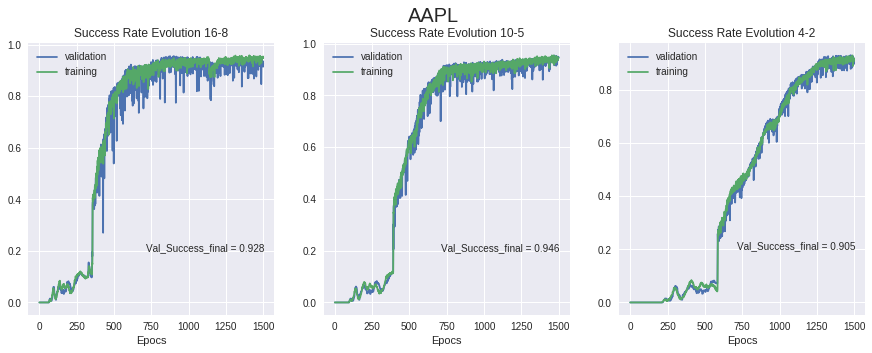

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 16-8
ax1.plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
ax1.plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
ax1.legend()
ax1.set_title('Success Rate Evolution 16-8')
ax1.set_xlabel('Epocs')
ax1.annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.2), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 10-5
ax2.plot(history_LSTM105.epoch,history_LSTM105.history['val_porcentaje_margen'],label='validation')
ax2.plot(history_LSTM105.epoch,history_LSTM105.history['porcentaje_margen'],label="training")
ax2.legend()
ax2.set_title('Success Rate Evolution 10-5')
ax2.set_xlabel('Epocs')
ax2.annotate('Val_Success_final = %.3f'% history_LSTM105.history['val_porcentaje_margen'][-1], (1250, 0.2), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la RNN 4-2
ax3.plot(history_LSTM42.epoch,history_LSTM42.history['val_porcentaje_margen'],label='validation')
ax3.plot(history_LSTM42.epoch,history_LSTM42.history['porcentaje_margen'],label="training")
ax3.legend()
ax3.set_title('Success Rate Evolution 4-2')
ax3.set_xlabel('Epocs')
ax3.annotate('Val_Success_final = %.3f'% history_LSTM42.history['val_porcentaje_margen'][-1], (1250, 0.2), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

Basandonos en los errores de entrenamiento decido que el mejor modelo para el activo MINI es el que tenga menor error, en este caso es el modelo de 16-8

In [13]:
# Calculo la prediccion para mi conjunto test
predictedLSTM105 = pd.DataFrame(model105.predict(Xtt))
predictedLSTM168 = pd.DataFrame(model168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseLSTM105 = sqrt(mean_squared_error(ytt, predictedLSTM105))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseLSTM105,rmseLSTM168)

651.82686162415 526.5745997191314


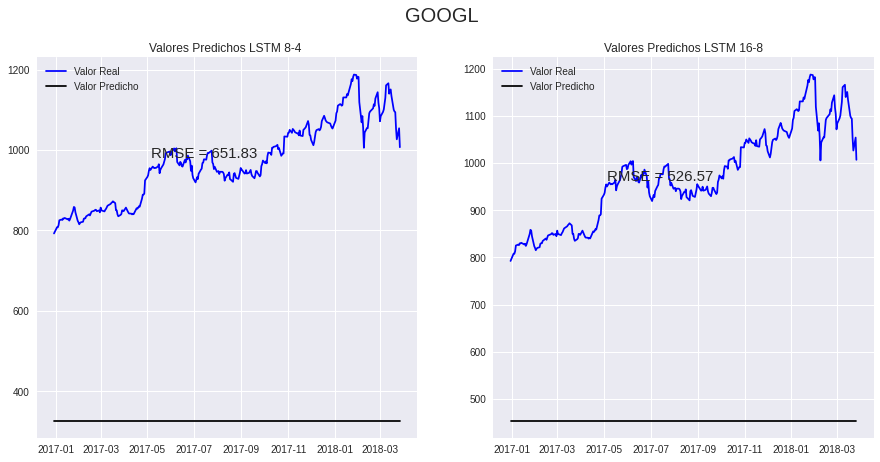

In [14]:
fig, axes = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la LSTM 10-5
axes[0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0].plot(index_time_t,predictedLSTM105, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos LSTM 8-4 ')
axes[0].annotate('RMSE = %.2f'% rmseLSTM105, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos LSTM 16-8')
axes[1].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)




plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [15]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedLSTM105
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 309})


In [138]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      132773        0      0  44.35  42.4567  -1
Valor Final = 132772.56
Ganancia con margen = 32772.56


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [139]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      233283        0          2703      0  44.35  42.4567  -1
Valor Final = 113404.90
Ganancia con margen = 13404.90


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [140]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      174259        0          2019      0  44.35  42.4567  -1
Valor Final = 84716.80
Ganancia con margen = -15283.20


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  